## Introduction

As everyone is an epidemiologist these days and tries to understand, predict and model the way the COVID-19 virus is spreading, I took the opportunity to work with the data myself.

Disclaimer: I am not trying to prove anything here, it's just some good exercise for my python skills and cognitive thinking. The analysis made is overly simplistic and it is not used to draw serious conclusions about the pandemic.

1. [Data preparation](#data)


2. [General Analysis](#general-analysis)


3. [Country Analysis](#country-analysis)

    3.1 [Analysis of Italy and Romania](#country-analysis)

    3.2 [Determining R<sub>0</sub> for Romania](#fit)

    3.3 [SIR model](#sir)

    3.4 [Case evolution comparison for countries with and without lockdown](#lockdown)    


4. [Hand wash correlation](#other)



In [37]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim # still in work
import matplotlib.dates as mdates
import seaborn as sns
from scipy import optimize
# use notebook for animation
%matplotlib inline 

In [38]:
#try API from bing

#x = requests.get('https://bing.com/covid/data').json()
#x.status_code
#x['areas']


In [39]:
#pd.read_json('https://bing.com/covid/data').head()

In [40]:
#pd.DataFrame(x['areas'])

<a name="data"></a>
## 1. Reading the file and cleaning the data

The file is read from the url directly using pandas. The file is compiled by the European Centre for Disease Prevention and Control, and can be found on the following page: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

It is updated daily, so, by any chance, the code gives an error somewhere, it means that the source data must be reviewd.

In [41]:
#reading in the excel file
data = pd.read_excel('https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx')
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-05-26,26,5,2020,591,1,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-05-25,25,5,2020,584,2,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-05-24,24,5,2020,782,11,Afghanistan,AF,AFG,37172386.0,Asia
3,2020-05-23,23,5,2020,540,12,Afghanistan,AF,AFG,37172386.0,Asia
4,2020-05-22,22,5,2020,531,6,Afghanistan,AF,AFG,37172386.0,Asia


In [42]:
# dropping columns we don't need
data.drop(['day','month','year','geoId'],axis =1, inplace = True)

In [43]:
# converting the date column to a datetime object
data['dateRep'] = pd.to_datetime(data['dateRep'])

In [44]:
# renaming columns
data = data.rename({'countriesAndTerritories':'country','countryterritoryCode':'code','dateRep':'date','popData2018':'pop'},axis=1)

In [45]:
data.head()

,date,cases,deaths,country,code,pop,continentExp
0,2020-05-26,591,1,Afghanistan,AFG,37172386.0,Asia
1,2020-05-25,584,2,Afghanistan,AFG,37172386.0,Asia
2,2020-05-24,782,11,Afghanistan,AFG,37172386.0,Asia
3,2020-05-23,540,12,Afghanistan,AFG,37172386.0,Asia
4,2020-05-22,531,6,Afghanistan,AFG,37172386.0,Asia


In [46]:
#fixing wrong data
data.loc[(data.country=="Italy") & (data.date=='2020-03-15'),'cases'] = 3590
data['country'] = data.country.str.replace("_",' ')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19457 entries, 0 to 19456
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          19457 non-null  datetime64[ns]
 1   cases         19457 non-null  int64         
 2   deaths        19457 non-null  int64         
 3   country       19457 non-null  object        
 4   code          19193 non-null  object        
 5   pop           19191 non-null  float64       
 6   continentExp  19457 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.0+ MB


<a name="general-analysis"></a>
## 2. General analysis 

In here, just some plots of the current stats of the pandemic across the globe.

In [47]:
#grouping the data by country

total_cases = pd.merge(data.groupby('country')['cases'].sum(),data.groupby('country')['pop'].mean(), on='country').reset_index().sort_values(by='cases',ascending=False)
total_cases.loc[:,"percentage"] = (total_cases['cases']/total_cases['pop'])*100
total_cases.loc[:,"percentage"] = total_cases.loc[:,"percentage"].round(2)

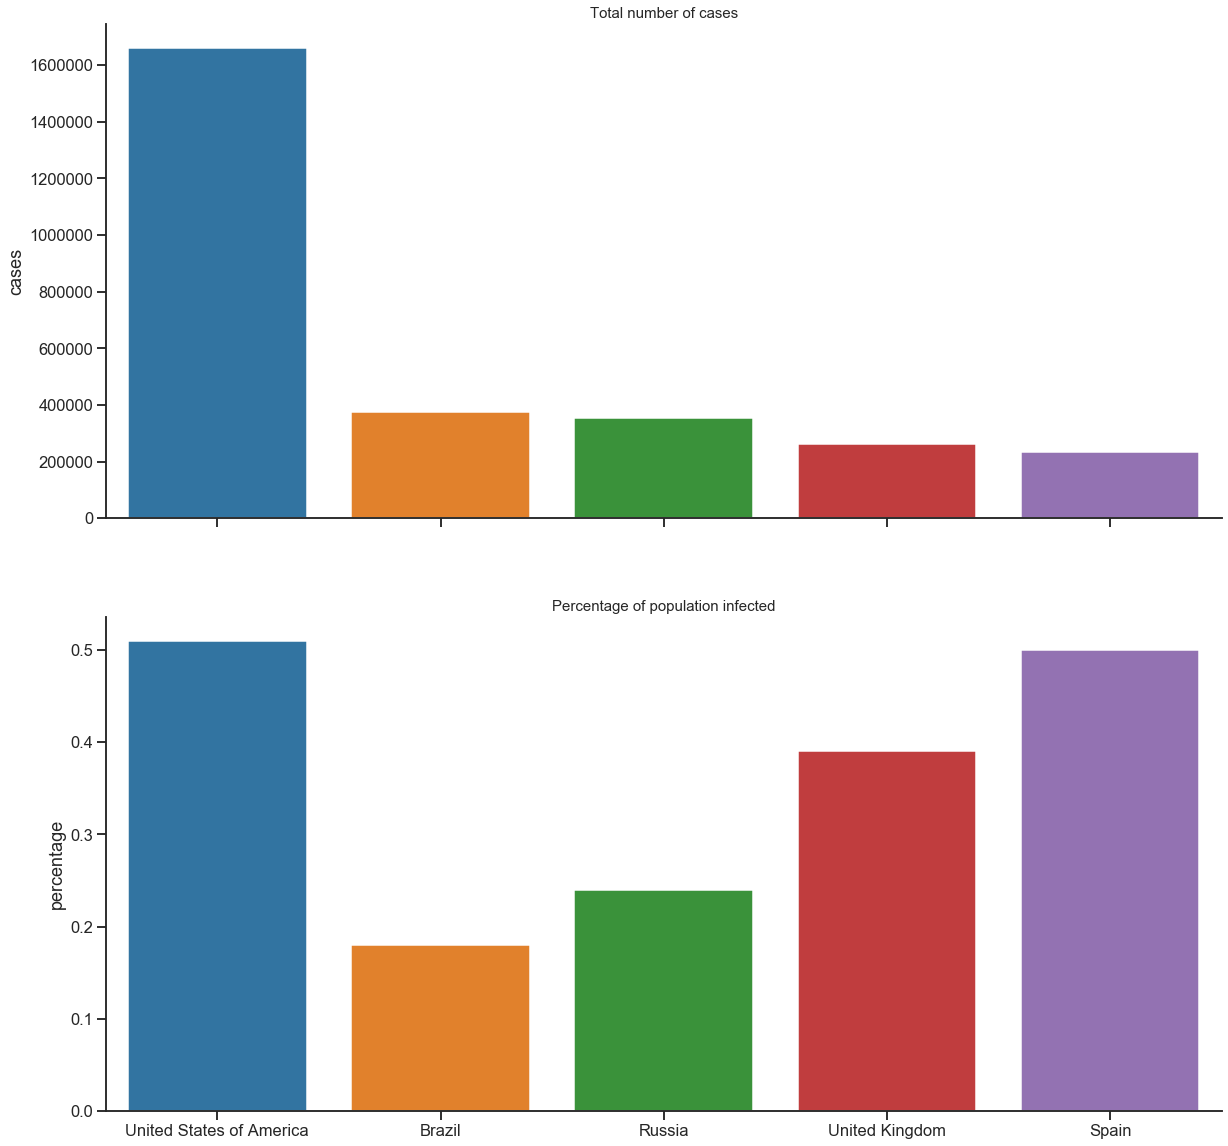

In [48]:
sns.set_style('ticks')
sns.set_context("talk")

fig = plt.figure(figsize=(20,20))
ax1,ax2 = fig.subplots(2,1,sharex=True)
sns.barplot(x='country', y='cases', data=total_cases.head(),ax=ax1)
sns.barplot(x='country', y='percentage',data=total_cases.head(),ax=ax2)
ax1.set_xlabel('')
ax1.set_title('Total number of cases',size = 15)
ax2.set_title('Percentage of population infected',size=15)
ax2.set_xlabel('')
sns.despine()

In [49]:
total_deaths = pd.merge(data.groupby('country')['deaths'].sum(),data.groupby('country')['pop'].mean(), on='country').reset_index().sort_values(by='deaths',ascending=False)
total_deaths.loc[:,"percentage"] = (total_deaths['deaths']/total_deaths['pop'])*100
total_deaths.loc[:,"percentage"] = total_deaths.loc[:,"percentage"].round(3)

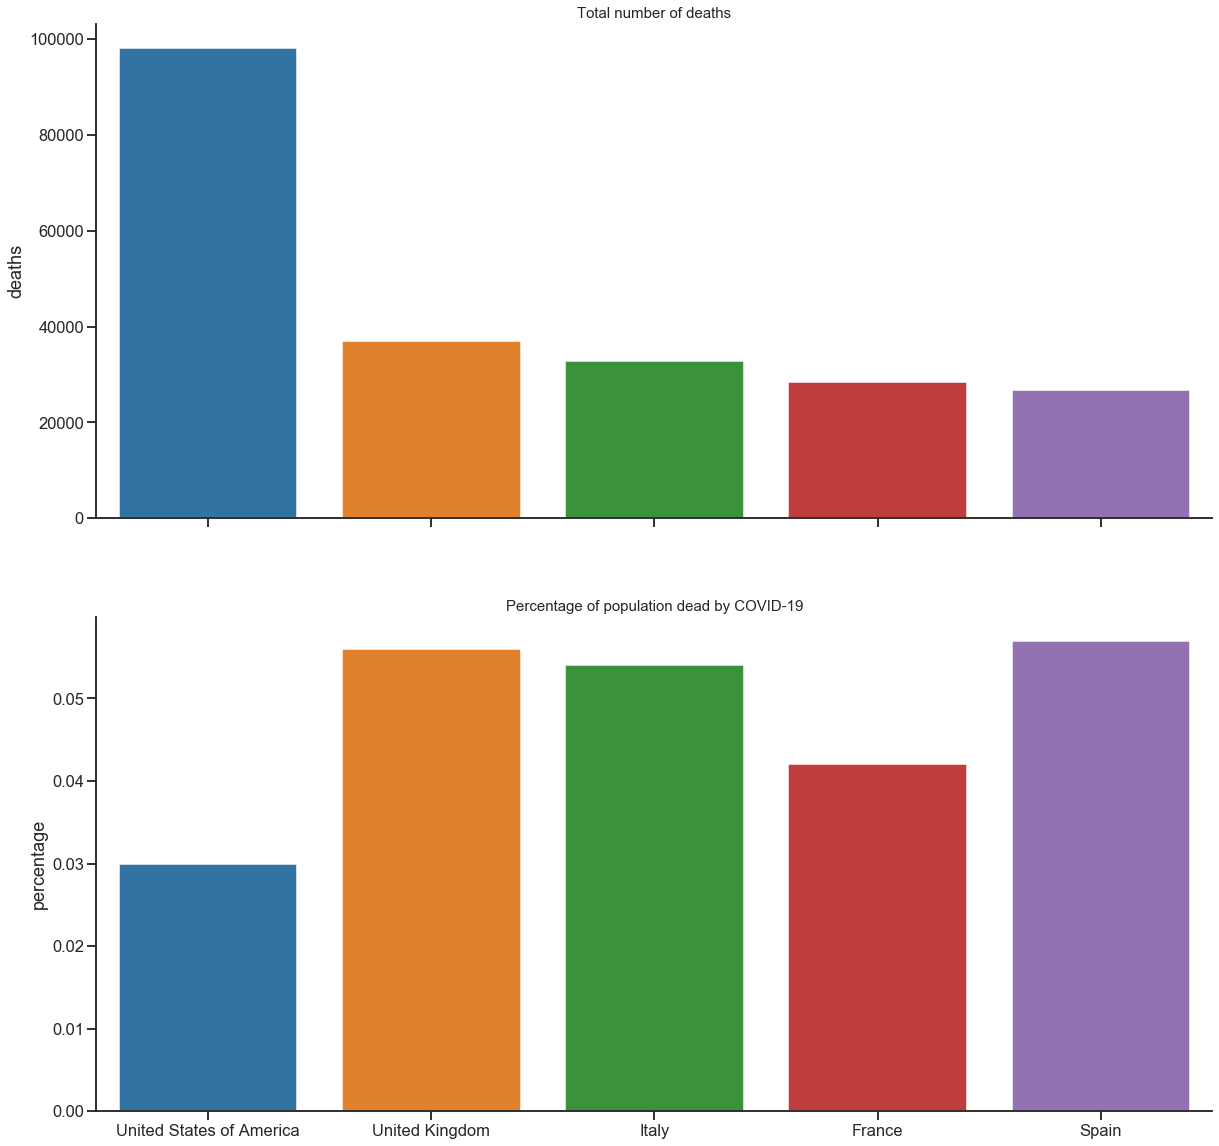

In [50]:
fig = plt.figure(figsize=(20,20))
ax1,ax2 = fig.subplots(2,1,sharex=True)
sns.barplot(x='country', y='deaths', data=total_deaths.head(),ax=ax1)
sns.barplot(x='country', y='percentage',data=total_deaths.head(),ax=ax2)
ax1.set_xlabel('')
ax1.set_title('Total number of deaths',size=15)
ax2.set_title('Percentage of population dead by COVID-19',size=15)
ax2.set_xlabel('')
sns.despine()

In [51]:
# fig = plt.figure(figsize=(10,5))
# ax1 = fig.add_subplot(1,1,1)
# data_reindexed = data.iloc[::-1]
# def animate(i):
#     for c in data.groupby('country')['cases'].sum().sort_values(ascending=False).head().index:
#         ax1.plot(data_reindexed.iloc[:i]['date'], data_reindexed[data_reindexed['country']==c].iloc[:i]['cases'],label="Number of new cases")
# ani = anim.FuncAnimation(fig, animate, interval=10)
# ax1.tick_params(axis='x',fontsize=1,labelrotation=45)
# ax1.legend(loc='upper left',labelsize=1)
# plt.show()

<a name="country-analysis"></a>
## 3. Country analysis

### 3.1 Analysis of Italy and Romania

Evolutions of the disease in Italy (one of the most affected countries in the world), and Romania. Its main goal is to see the way the spread occured, predicting some theoretical values and comparing them.

In [52]:
# selecting the countries we will do an analysis on, starting from the first date with a reported case
italy = data.loc[(data.country=="Italy") & (data.cases>0)]
romania = data.loc[(data.country=="Romania") & (data.cases>0)]

In [53]:
# sorting the values and creating columns for theoretical exponential graphs
italy.loc[:,'low_exp'] = 1
italy.loc[:,'high_exp'] = 1
italy = italy.sort_values(by='date')
romania.loc[:,'low_exp'] = 1
romania.loc[:,'high_exp'] = 1
romania = romania.sort_values(by='date')

C:\Users\vlade\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\vlade\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [54]:
# resetting the index
italy.reset_index(inplace = True, drop = True) 
italy.head()
romania.reset_index(inplace = True, drop = True) 
romania.head()

,date,cases,deaths,country,code,pop,continentExp,low_exp,high_exp
0,2020-02-27,1,0,Romania,ROU,19473936.0,Europe,1,1
1,2020-02-29,2,0,Romania,ROU,19473936.0,Europe,1,1
2,2020-03-04,1,0,Romania,ROU,19473936.0,Europe,1,1
3,2020-03-06,2,0,Romania,ROU,19473936.0,Europe,1,1
4,2020-03-07,1,0,Romania,ROU,19473936.0,Europe,1,1


In epidemiology, the basic reproduction number (sometimes called basic reproductive ratio, or incorrectly basic reproductive rate, and denoted R0, pronounced R nought or R zero[17]) of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection.

For COVID-19, it is suggested to be between 1.4 -3.9 [source](https://en.wikipedia.org/wiki/Basic_reproduction_number)

This will help us draw the "expected" graph of the infection rate, in the case where no measures would be taken whatsoever to prevent spread of the disease. We will draw the best and worst scenarios for disease spread.

In [55]:
#creating the theoretical exponential curves
for i in range(1, len(italy)):
    italy.loc[i,'low_exp'] = italy.loc[i-1,'low_exp'] * 1.4
    italy.loc[i,'high_exp'] = italy.loc[i-1,'high_exp'] * 3.9
for i in range(1, len(romania)):
    romania.loc[i,'low_exp'] = romania.loc[i-1,'low_exp'] * 1.4
    romania.loc[i,'high_exp'] = romania.loc[i-1,'high_exp'] * 3.9

In [56]:
italy['total'] = italy['cases'].cumsum()
romania['total'] = romania['cases'].cumsum()

In [57]:
italy.head()

,date,cases,deaths,country,code,pop,continentExp,low_exp,high_exp,total
0,2020-01-31,3,0,Italy,ITA,60431283.0,Europe,1.0000,1.0000,3
1,2020-02-22,14,0,Italy,ITA,60431283.0,Europe,1.4000,3.9000,17
2,2020-02-23,62,2,Italy,ITA,60431283.0,Europe,1.9600,15.2100,79
3,2020-02-24,53,0,Italy,ITA,60431283.0,Europe,2.7440,59.3190,132
4,2020-02-25,97,4,Italy,ITA,60431283.0,Europe,3.8416,231.3441,229


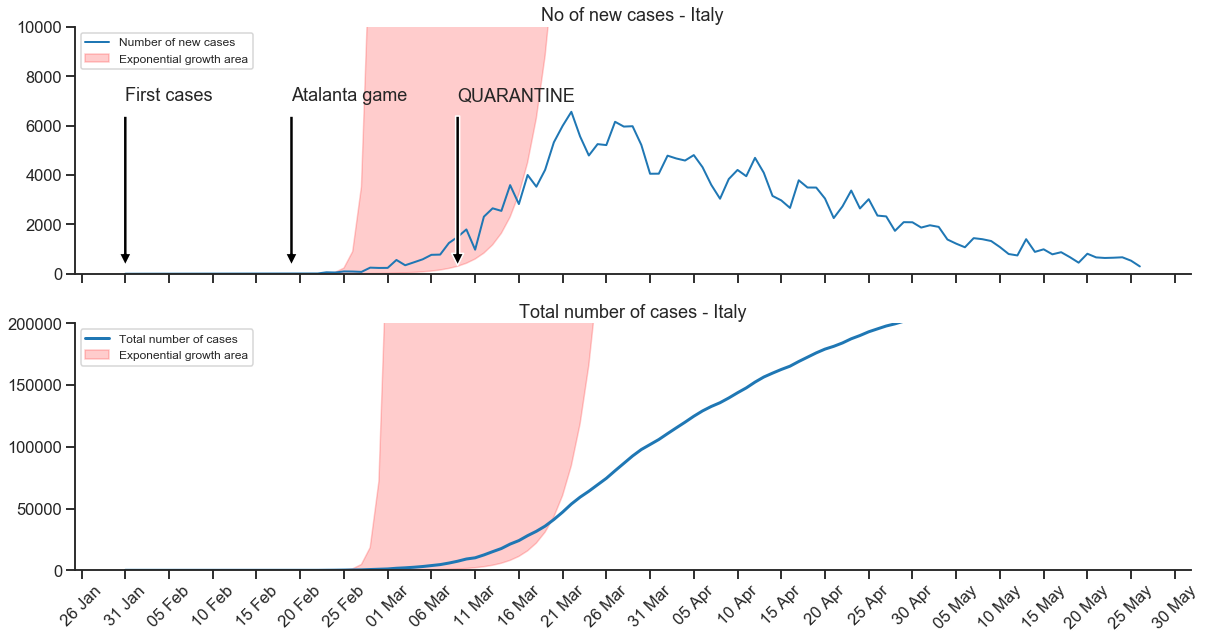

In [58]:
# The Pandas ↔ Matplotlib converters must be manually registered 
pd.plotting.register_matplotlib_converters()

# creating the graphs
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(italy['date'], italy['cases'],linewidth=2,label="Number of new cases")
ax1.fill_between(italy['date'], italy['low_exp'],italy['high_exp'],color='red',label='Exponential growth area',alpha=0.2)
ax1.annotate('QUARANTINE',('2020-03-09',0),('2020-03-09',7000),arrowprops=dict(facecolor='black', shrink=0.05) )
ax1.annotate('Atalanta game',('2020-02-19',0),('2020-02-19',7000),arrowprops=dict(facecolor='black', shrink=0.05) )
ax1.annotate('First cases',('2020-01-31',0),('2020-01-31',7000),arrowprops=dict(facecolor='black', shrink=0.05) )
ax1.set_ylim(0,10000)
ax1.set_title('No of new cases - Italy')
ax1.legend(loc='upper left',fontsize=12)
ax1.set_xticklabels([])
ax2.plot(italy['date'], italy['total'],label="Total number of cases",linewidth=3)
ax2.fill_between(italy['date'], italy['low_exp'].cumsum(),italy['high_exp'].cumsum(),color = 'red',alpha = 0.2,label='Exponential growth area')
ax2.tick_params(axis='x',labelrotation=45)
ax2.set_ylim(0,200000)
ax2.legend(loc='upper left',fontsize=12)
ax2.set_title('Total number of cases - Italy')
#format date ticks
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
sns.despine()


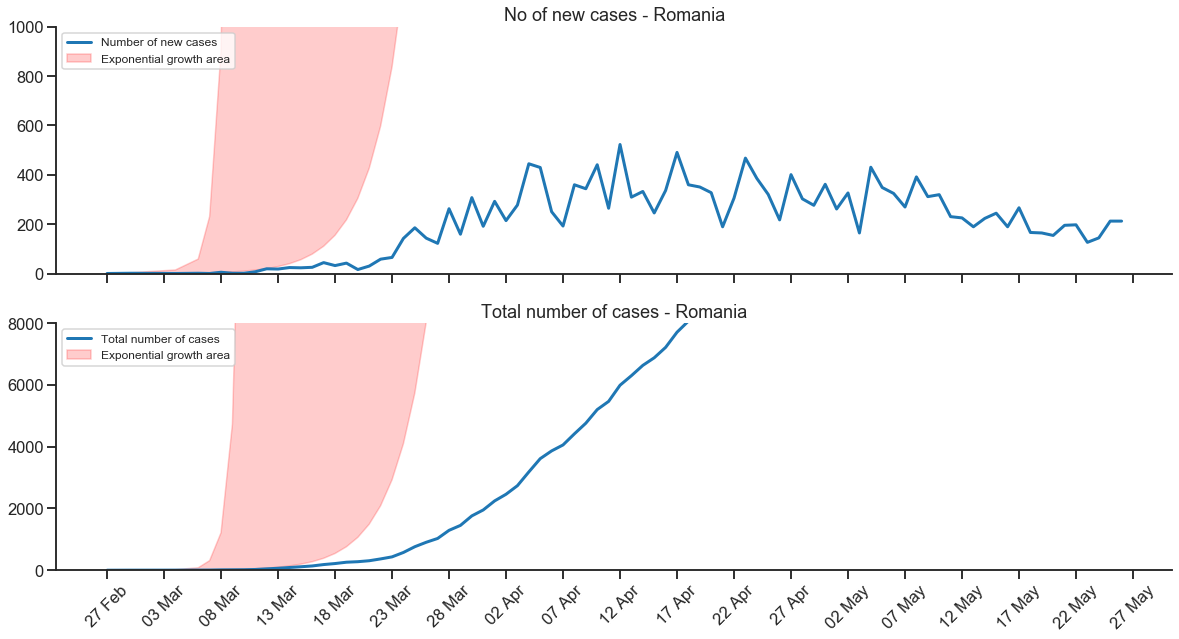

In [59]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.fill_between(romania['date'], romania['low_exp'],romania['high_exp'],label='Exponential growth area',alpha=0.2, color='red')
ax1.plot(romania['date'], romania['cases'],linewidth=3,label="Number of new cases")
ax1.set_ylim(0,1000)
ax1.legend(loc='upper left',fontsize=12)
ax1.set_xticklabels([])
ax1.set_title('No of new cases - Romania')
ax2.plot(romania['date'], romania['total'],linewidth=3,label="Total number of cases")
ax2.fill_between(romania['date'], romania['low_exp'].cumsum(),romania['high_exp'].cumsum(), label='Exponential growth area',alpha=0.2, color='red')
ax2.tick_params(axis='x',labelrotation=45)
ax2.set_ylim(0,8000)
ax2.set_title('Total number of cases - Romania')
ax2.legend(loc='upper left',fontsize=12)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
sns.despine()

<a name="fit"></a>
### 3.2 Determining R<sub>0</sub> for Romania

In order to try and get a rough estimate of what the R<sub>0</sub> value is in Romania, we will try to fit an exponential function (day<sup>R<sub>0</sub></sup>) to our data and get the best results.

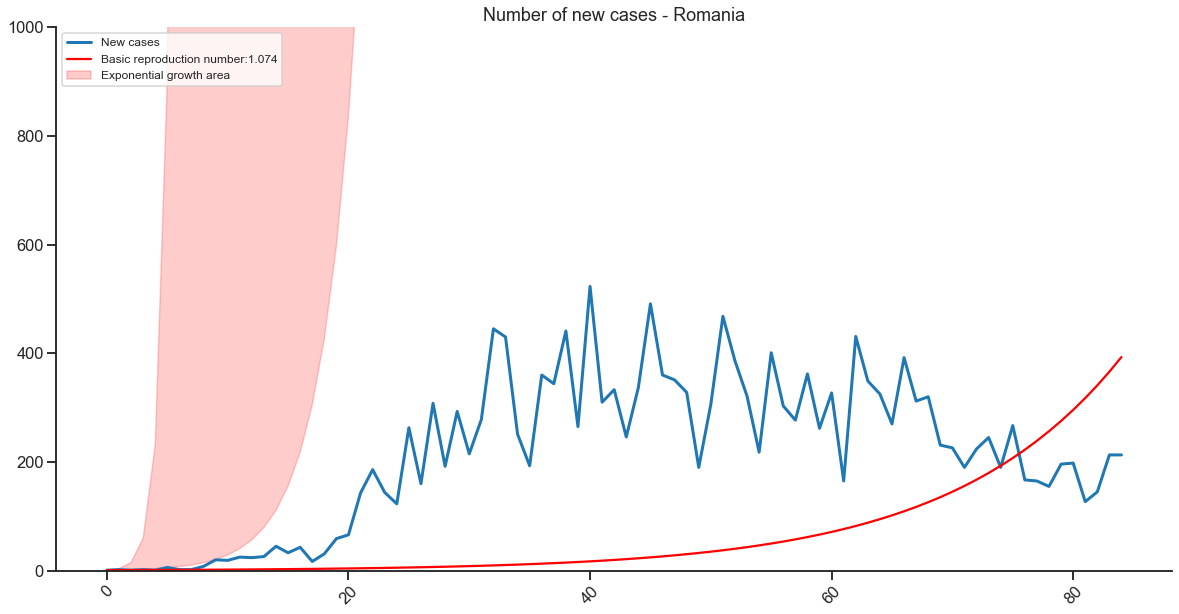

In [60]:
#define function and get params
def func(x, a):
    return a**x
popt, pcov = optimize.curve_fit(func, romania.index, romania['cases'])

fig, ax =plt.subplots(figsize=(20,10))

ax.plot(romania.index, romania['cases'],linewidth=3,label="New cases")
ax.plot(romania.index, func(romania.index, *popt), 'r',
    label='Basic reproduction number:%.3f' % popt[0])
ax.fill_between(romania.index, romania['low_exp'],romania['high_exp'], label='Exponential growth area',alpha=0.2, color='red')
ax.tick_params(axis='x',labelrotation=45)
ax.set_ylim(0,1000)
ax.set_title('Number of new cases - Romania')
ax.legend(loc='upper left',fontsize=12)
sns.despine()



<a name="sir"></a>
### 3.3 SIR model
A better way to predict an epidemic is using the **SIR** model (Susceptible, Infected, Recovered). First developed by Kermack and McKendrick in a paper they published in 1927 ([link](https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118)), the model is widely used to give a fairy good outlook of an epidemic spread.

It is based on the following 3 differential equations:

\begin{align}
\frac{dS}{dt} & = \frac{-\beta{SI}}{N} \\   
\frac{dI}{dt} & = \frac{\beta{SI}}{N} - \gamma{I} \\
\frac{dR}{dt} & = \gamma{I} \\
\end{align}

,where $\beta$ and $\gamma$ are two constants: the effective contact rate of the disease( an infected individual comes into contact with $\beta$N individuals per unit time) and the recovery rate respectively ( 1/$\gamma$ is the mean period of time an infected individual can pass it on).

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations

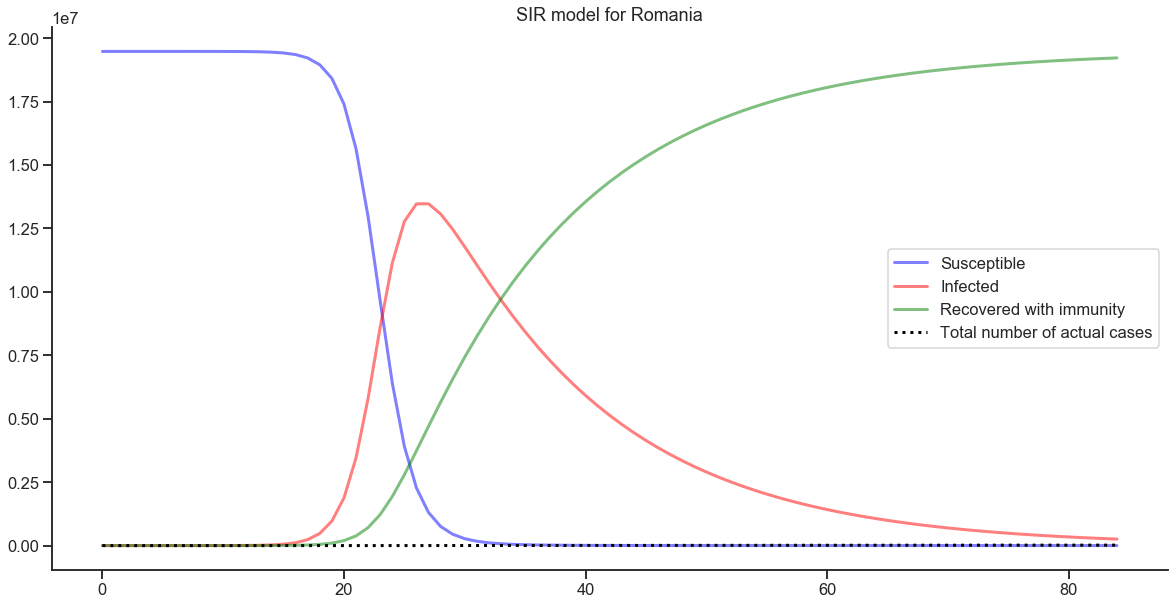

In [61]:
from scipy.integrate import odeint

# Total population, N
N = romania['pop'].mean()
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma =0.8, 1./14 


# The SIR model differential equations.
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt



t =romania.index


# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax =plt.subplots(figsize=(20,10))
ax.set_title("SIR model for Romania")
ax.plot(t, S, 'b', alpha=0.5, lw=3, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=3, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=3, label='Recovered with immunity')
ax.plot(romania.index, romania['total'],linewidth=3,linestyle = 'dotted',label="Total number of actual cases",color='black')
sns.despine()
ax.legend()

By inserting the whole country population as N, the graph really doesn't show anything meaningful, as the spread of the disease in the real case is too low.

<a name="lockdown"></a>
### 3.4 Case evolution comparison for countries with and without lockdown

In order to see if lockdown is a necessity to keep the number of cases down, we will compare some european countries which have a total lockdown vs ones which have only partial, or no lockdown.

We will scrape the data from the wikipedia page containg a table of countries and their respective dates of lockdown (https://en.wikipedia.org/wiki/National_responses_to_the_2019%E2%80%9320_coronavirus_pandemic)

In [62]:
# parse web
import requests
from bs4 import BeautifulSoup

response = requests.get('https://en.wikipedia.org/wiki/National_responses_to_the_2019%E2%80%9320_coronavirus_pandemic').text
parser = BeautifulSoup(response,'html.parser')

In [63]:
table = parser.find('table',class_="wikitable sortable mw-collapsible")

In [64]:
data_list = []

for row in table.find('tbody').find_all('tr'):
    data_list.append(row.text.strip().split('\n\n'))

In [65]:
for l in data_list:
    if len(l) <5:
        l.insert(1,'')

In [66]:
data_list.pop(0)
col_names = data_list.pop(0)
col_names

['Countries and territories', 'Place', 'Start date', 'End date', 'Level']

In [67]:
lockdowns = pd.DataFrame(data_list)

In [68]:
lockdowns.isnull().sum()
lockdowns = lockdowns.loc[:,:4]


In [69]:
lockdowns.columns = col_names

In [70]:
lockdowns.head()

,Countries and territories,Place,Start date,End date,Level
0,Albania,,2020-03-13[3],,National
1,Algeria,,2020-03-23[4],2020-05-14[5],City
2,Argentina,,2020-03-19[6],2020-05-24[7],National
3,Armenia,,2020-03-24[8],2020-05-04[9],None
4,Australia,,2020-03-23[10],None,None


In [71]:
lockdowns.drop(lockdowns[lockdowns.isnull().sum(axis=1) >1].index,inplace=True)

In [72]:
lockdowns.drop("Place",axis=1, inplace=True)
# lockdowns.drop(120,inplace=True)

In [73]:
lockdowns.drop('Level',axis=1,inplace=True)
lockdowns.rename({'Countries and territories':'country','Start date' : 'lockdown start','End date':'lockdown end'},axis=1,inplace =True)

In [74]:
non_countries = ['São Paulo','Suva','Guernsey','Northern Cyprus', 'Jalan Bani Bu Ali','Davao Region', 'Luzon', 'Soccsksargen',
                 'Rest of Russia: Mandatory holidays\nand further measures in each region', 'Qatif', 'Riyadh',
                'Clark County, NV', 'Connecticut', 'Illinois',
       'Kansas City, KS', 'Massachusetts', 'Michigan', 'New York',]
lockdowns.drop(lockdowns[lockdowns['country'].isin(non_countries)].index,inplace=True)

In [75]:
merged_lockdowns = pd.merge(data,lockdowns, on='country')

In [76]:
merged_lockdowns['lockdown start'] = merged_lockdowns['lockdown start'].str.slice(stop=10)
merged_lockdowns['lockdown start'] = pd.to_datetime( merged_lockdowns['lockdown start'])

merged_lockdowns['lockdown end'] = merged_lockdowns['lockdown end'].str.slice(stop=10)
merged_lockdowns['lockdown end'] = pd.to_datetime( merged_lockdowns['lockdown end'])


In [77]:
merged_lockdowns.head()

,date,cases,deaths,country,code,pop,continentExp,lockdown start,lockdown end
0,2020-05-26,6,0,Albania,ALB,2866376.0,Europe,2020-03-13,NaT
1,2020-05-25,9,1,Albania,ALB,2866376.0,Europe,2020-03-13,NaT
2,2020-05-24,8,0,Albania,ALB,2866376.0,Europe,2020-03-13,NaT
3,2020-05-23,12,0,Albania,ALB,2866376.0,Europe,2020-03-13,NaT
4,2020-05-22,5,0,Albania,ALB,2866376.0,Europe,2020-03-13,NaT


In [78]:
lockdown_starts = merged_lockdowns.groupby('country')[['lockdown start']].agg(lambda x:x[0])
lockdown_ends = merged_lockdowns.groupby('country')[['lockdown end']].agg(lambda x:x[0])
lockdown_ends= lockdown_ends[lockdown_ends['lockdown end'].notna()]

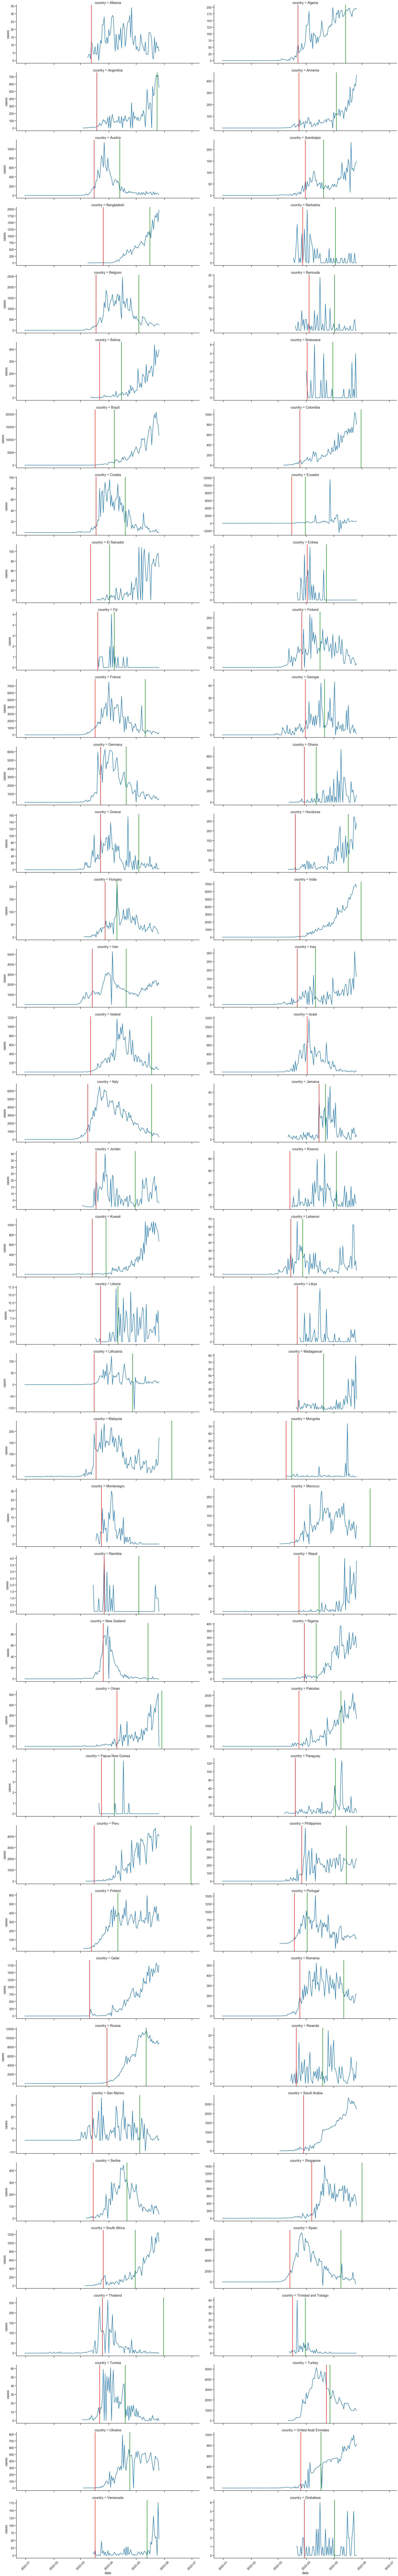

In [87]:
g = sns.FacetGrid(merged_lockdowns, col="country", col_wrap=2, height=5, aspect=3, sharey= False,sharex=True)
g.map(sns.lineplot, "date", "cases")
for ax in g.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.axvline(lockdown_starts[lockdown_starts.index == ax.get_title()[10:]]['lockdown start'],color='r')
    if ax.get_title()[10:] in lockdown_ends.index:
        ax.axvline(lockdown_ends[lockdown_ends.index == ax.get_title()[10:]]['lockdown end'],color='g')

# red line = lockdown start
# green line = lockdown end

<a name="other"></a>
## 4. Hand wash correlation

I remembered about a map of Europe and the percentage of people who wash their hands after going to the toilet, for each country. I thought it would be fun to see if the numbers correlated in any way with the number of total cases.

The data comes from this survey: https://www.bva-group.com/sondages/les-francais-et-le-savonnage-des-mains-apres-etre-alle-aux-toilettes/

I had to translate the country names into english and added them alongside their respective percentages in the csv.


In [80]:
hand_wash = pd.read_csv('hand_wash_data.csv',header=None,names=['country',"percentage"])

In [81]:
hand_wash['percentage'] = hand_wash['percentage'].str.replace('%','').astype('float')


In [82]:
data_wash = data.groupby('country')['cases'].sum().reset_index()

In [83]:
data_wash['country'] = data_wash['country'].str.replace('_',' ')


In [84]:
data_wash = pd.merge(data_wash, hand_wash, on="country")

In [85]:
# to add the coefficient to the regression graph, we need to calculate them with scipy.stats first, seaborn doesn't offer that function
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(data_wash['cases'],data_wash['percentage'])
#print(slope, intercept, r_value, p_value, std_err)

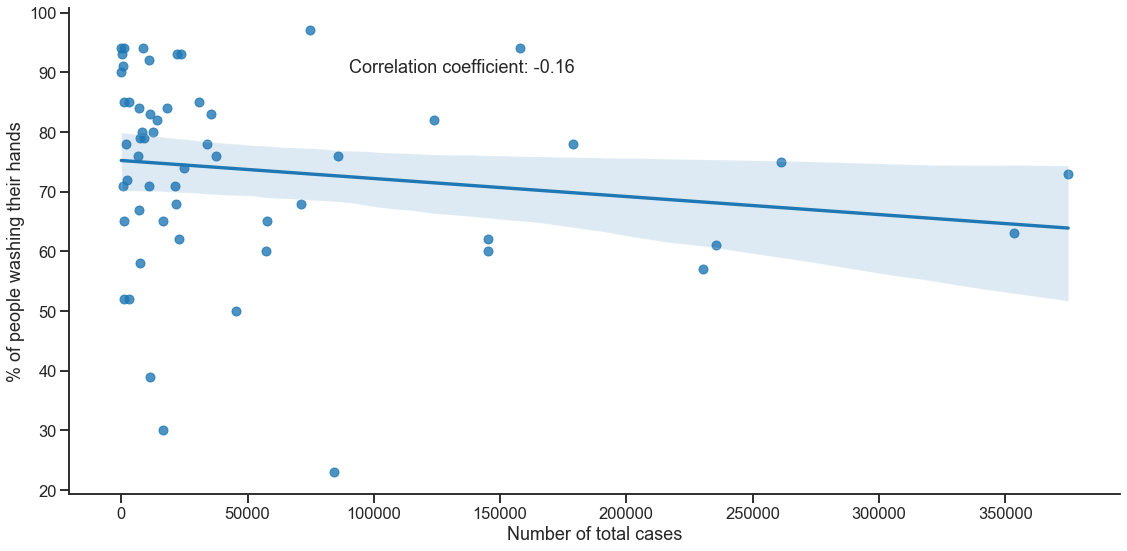

In [86]:
sns.lmplot(x='cases',y='percentage',data=data_wash,height=8,aspect=2)
plt.xlabel('Number of total cases')
plt.ylabel('% of people washing their hands')
plt.annotate('Correlation coefficient: {:.2f}'.format(r_value), xy=(90000,90));

#following code for showing all the country names
# for c in range(0,data_wash.shape[0]):
#      plt.text(data_wash.cases[c]+0.01, data_wash.percentage[c], 
#      data_wash.country[c], horizontalalignment='left', 
#      size='medium', color='black')

The correlation coefficint is too low to believe there is a real correlation between hand-wash habits and the spread of the disease.